# RP3xFlow Ensemble

#### Status

- Implemented Part 1 with example UCITS ETFs

## Introduction

Inspired by the fine folks at https://robotwealth.com/

Long-only volatility targeted ensemble, including:

- Risk premia harvesting strategy
- Turn-of-month flow effects strategy: bond window dressing, equity vs bond rebalance, equity rebalance

Asset universe, including:

- Equity ETF e.g. $VTI
- Bond ETF e.g. $TLT
- Gold ETF e.g. $GLD

Notebook organised into 3 parts:

1. Risk premia harvetsing strategy
2. Turn-of-month flow effect strategy
3. Portfolio ensemble

## Part 1: Risk Premia Harvesting Strategy

Rules:
- Long a basket of diversified risk assets and re-invest distributions
- Allocate based on a per asset volatility target
- Rebalance when asset weights deviate more a percentage threshold

### 1a: Define imports and strategy parameters

In [118]:
import datetime
import calendar
import warnings
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Map asset class to instrument
equity_ticker = 'VNRT.L'
bond_ticker = 'IBTL.L'
gold_ticker = 'SGLN.L'
universe_tickers = [equity_ticker, bond_ticker, gold_ticker]

# Map instrument to currency denomination factor e.g. GBP = 1, GBX/GBp = 0.01
equity_ticker_denom = 1
bond_ticker_denom = 0.01
gold_ticker_denom = 0.01

# Assetwise volatility targets
equity_vol_target = 0.03
bond_vol_target = 0.03
gold_vol_target = 0.03

# Assetwise re-balance threshold as % of target position sizes 
rebalance_threshold = 0.2

# Calendar days to load data for each asset class
hist_price_period_days = 5 * 365

# Day periods to use for volatility estimation
vol_forecast_period_days = 60

# Portfolio positions used to calculate NAV and order deltas
cash_value = 1000
equity_pf_qty = 2.5
bond_pf_qty = 0
gold_pf_qty = 0

### 1b: Load asset universe data

Load historic adjusted close prices for our universe for last x days.

In [119]:
# Set period to load data, noting these are calendar days not trading days
period_end = datetime.datetime.utcnow()
period_start = period_end - datetime.timedelta(days=hist_price_period_days)

# Get daily adjusted close data from Yahoo Finance for our universe
asset_df = pdr.get_data_yahoo(universe_tickers, start=period_start, end=period_end)[['Adj Close']]

# Standardize names
asset_df = asset_df.reset_index()
asset_df = asset_df.rename_axis(columns={'Attributes': 'attribute', 'Symbols': 'ticker'})
asset_df = asset_df.rename(columns={'Date': 'date', 'Adj Close': 'price'})

# Normalize prices to use the same denomination
asset_df['price', equity_ticker] = asset_df['price', equity_ticker] * equity_ticker_denom
asset_df['price', bond_ticker] = asset_df['price', bond_ticker] * bond_ticker_denom
asset_df['price', gold_ticker] = asset_df['price', gold_ticker] * gold_ticker_denom

# Save price data to local feather file
feather_prep_df = asset_df.copy()
feather_prep_df.columns = feather_prep_df.columns.map(str)
feather_prep_df.to_feather("./prices.feather")

asset_df.tail(5)


attribute       date      price                 
ticker                   VNRT.L   IBTL.L  SGLN.L
1259      2022-08-26  85.297501  3.57400  28.745
1260      2022-08-30  83.525002  3.59000  28.835
1261      2022-08-31  83.532501  3.59950  28.800
1262      2022-09-01  82.709999  3.53350  28.635
1263      2022-09-02  84.529999  3.53175  28.860

### 1c: Enrich our asset data

Calculate and visualize derived metrics such as total returns and rolling volatility.

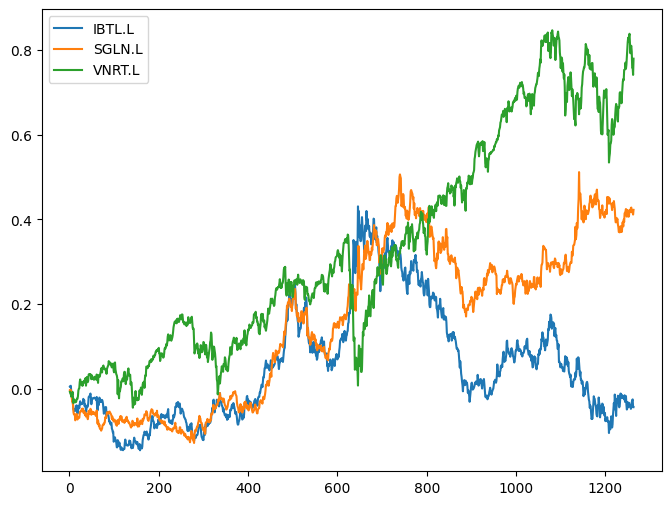

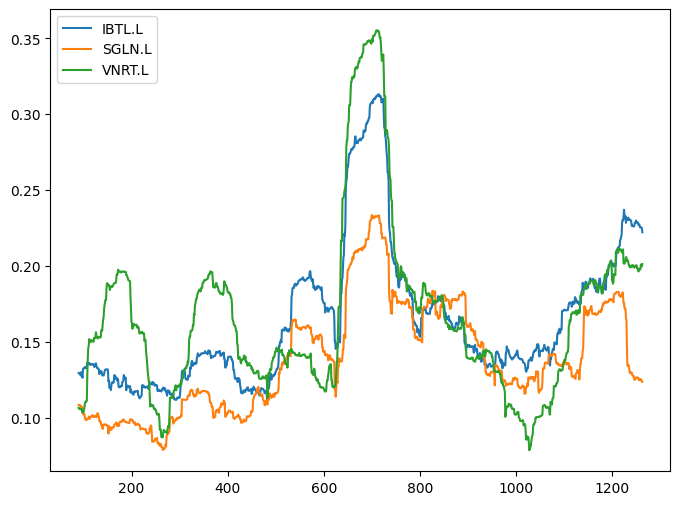

In [120]:
for ticker in universe_tickers:
    # Calculate total returns
    asset_df['return', ticker] = asset_df['price', ticker].pct_change()
    asset_df['log_return', ticker] = np.log(asset_df['price', ticker]/asset_df['price', ticker].shift(1))
    asset_df['cum_return', ticker] = (1 + asset_df['return', ticker]).cumprod() - 1
    asset_df['cum_log_return', ticker] = asset_df['log_return', ticker].cumsum()

    # Calculate rolling annual volatility for key periods
    asset_df['rolling_xd_ann_vol', ticker] = asset_df['log_return', ticker].rolling(vol_forecast_period_days).std() * math.sqrt(252)
    asset_df['rolling_30d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(30).std() * math.sqrt(252)
    asset_df['rolling_60d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(60).std() * math.sqrt(252)
    asset_df['rolling_90d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(90).std() * math.sqrt(252)

asset_df = asset_df.sort_index(axis='columns', level=1)

asset_df['cum_return'].plot(figsize=(8,6))
plt.legend(loc=2)

asset_df['rolling_90d_ann_vol'].plot(figsize=(8, 6))
plt.legend(loc=2)


### 1d: Calculate target positions

Compute target position sizes based on annualized volatility and instruct trade if delta exceeds rebalance threshold.

In [121]:
# Get asset data for last session as a series
latest_ds = asset_df.iloc[-2]

# Select close prices to calculate portfolio NAV
equity_price = latest_ds['price', equity_ticker]
bond_price = latest_ds['price', bond_ticker]
gold_price = latest_ds['price', gold_ticker]
portfolio_nav = cash_value + (equity_pf_qty * equity_price) + (bond_pf_qty * bond_price) + (gold_pf_qty * gold_price)

# Build dataframe of portfolio and target positions
portfolio_df = pd.DataFrame({'ticker': universe_tickers})
portfolio_df['date'] = latest_ds['date', '']
portfolio_df['price'] = [equity_price, bond_price, gold_price]
portfolio_df['ann_vol'] = [
        latest_ds['rolling_xd_ann_vol', equity_ticker],
        latest_ds['rolling_xd_ann_vol', bond_ticker],
        latest_ds['rolling_xd_ann_vol', gold_ticker]]
portfolio_df['vol_target'] = [equity_vol_target, bond_vol_target, gold_vol_target]
portfolio_df['portfolio_qty'] = [equity_pf_qty, bond_pf_qty, gold_pf_qty]
portfolio_df['target_qty'] = (portfolio_df['vol_target'] / portfolio_df['ann_vol']) * (portfolio_nav / portfolio_df['price'])
portfolio_df['delta_qty'] = (portfolio_df['target_qty'] - portfolio_df['portfolio_qty'])
portfolio_df['delta_pct'] = (portfolio_df['delta_qty'].abs() / portfolio_df['portfolio_qty'])

# Based on the assetwise rebalance param indicate if trade should be executed
portfolio_df['do_trade'] = portfolio_df['delta_pct'].apply(lambda x: True if (x >= rebalance_threshold) or math.isinf(x) else False)

portfolio_df

,ticker,date,price,ann_vol,vol_target,portfolio_qty,target_qty,delta_qty,delta_pct,do_trade
0,VNRT.L,2022-09-01,82.709999,0.194966,0.03,2.5,2.245074,-0.254926,0.10197,False
1,IBTL.L,2022-09-01,3.533500,0.223561,0.03,0.0,45.829567,45.829567,inf,True
2,SGLN.L,2022-09-01,28.635000,0.119830,0.03,0.0,10.550778,10.550778,inf,True


## Part 2: Turn-of-Month Flow Effects Strategy

This strategy consists of 3 sub-strategies that are combined into an ensemble with a shared volatility target.

In part 3, we then combine the flow effects ensemble with the risk premia harvesting strategy from part 1 to create a mega-ensemble that determines the final target positions of our portfolio.

### 2a: Strategy parameters

In addition to those defined in Part 1 we define specific params for this strategy.

In [122]:
# Volatility contribution from this specfific strategy
flow_effects_vol_target = 0.03

# Trading venue for the asset universe
exchange_label = 'LSE'

# Window dressing strat: trading day of month to go long bonds
wd_long_from_day = 5

# Equity reversion strat: trading day of month to evaluate equity returns
er_day = 10


### 2b: Load trading calendar

All the sub-strategies depend on evaluating the current trading day of the month for the specified exchange.

In [123]:
# Load trading venue calendar and timezone
exch_cal = mcal.get_calendar(exchange_label)
exch_today = datetime.datetime.now(exch_cal.tz).date()

# Define date range as start of current month and end of next month
cal_range_start = datetime.date(year=exch_today.year, month=exch_today.month, day=1)
cal_range_end_day = calendar.monthrange(year=exch_today.year, month=exch_today.month)[1]
cal_range_end = datetime.date(year=exch_today.year, month=exch_today.month, day=cal_range_end_day)

# Load trading venue sessions for current month using date range
exch_sched_df = exch_cal.schedule(start_date=cal_range_start, end_date=cal_range_end)
exch_eom = exch_sched_df.iloc[-1]['market_close'].date()

### 2c: Window dressing sub-strategy

Purpose is to determine if we should be long or short bonds based on current day of month.

Rules:
- Long after first trading week (to capture return on increasing demand from window dressing towards month end)
- Short at last day of month and thru first trading week (to capture return on reversion to fair-price)

In [133]:
# Default position is flat (no trade) 1 = Long, -1 = Short
wd_position = 0

# Evaluate trade direction based on current date
# Short when today is between last trading day of month AND go long day of next month
# Long when today is equal to or later than start of month trading day param
wd_long_date = exch_sched_df.iloc[wd_long_from_day]['market_close'].date()
if exch_today == exch_eom or exch_today < wd_long_date:
    wd_position = -1
else:
    wd_position = 1 

print('Today is %s in exchange timezone of %s' % (exch_today, exch_cal.tz.zone))
print('Go long from %s' % wd_long_date)
print('Current trade direction is %s' % wd_position)

Today is 2022-09-03 in exchange timezone of Europe/London
Go long from 2022-09-08
Current trade direction is -1


### 2d: Equity reversion sub-strategy

Purpose is to determine if we should be long or short equities later in month based on the return performance of equities in the earlier part of the month.

Rules:

- If returns are positive for the first x days of the month, get short, else get long
- Close the position at end of month

In [134]:
# Default position is flat (no trade) 1 = Long, -1 = Short
er_position = 0

# Get date that marks end of the period to measure equity returns
er_date = exch_sched_df.iloc[er_day]['market_close'].date()

# Sum the log returns for the period to assess equity performance
er_sum_ret = asset_df[
    (asset_df['date',] >= pd.Timestamp(exch_today.year, exch_today.month, 1)) &
    (asset_df['date',] <= pd.Timestamp(er_date))
]['log_return', equity_ticker].sum()

# If today has advanced past eval period instruct trade direction
# Positive return = short (-1), negative return = long (+1)
if exch_today > er_date:
    if er_sum_ret > 0:
        er_position = -1
    elif er_sum_ret < 0:
        er_position = 1

# If last trading day of month then close trade (invert sign)
if exch_today == exch_eom:
    er_position = er_position * -1

print('Today is %s in exchange timezone of %s' % (exch_today, exch_cal.tz.zone))
print('Evaluate returns until close on %s' % er_date)
print('Sum of log returns month-to-date is %f' % er_sum_ret)
print('Current trade direction is %s' % er_position)

Today is 2022-09-03 in exchange timezone of Europe/London
Evaluate returns until close on 2022-09-15
Sum of log returns month-to-date is 0.011871
Current trade direction is 0
